In [0]:
from google.colab import drive # access data in Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
weightsPath = '/content/gdrive/My Drive/Liver_Segmentation/Weights/our_model/unet_2channels.h5'

numOfSlices = 1
numOfChannels = 2
batchSize = 10

In [0]:
#@title Input data acquisition {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

fullLiver = False  # Full liver (created by) Liver+lesion # STEP 1 in 2-STEPS-MODEL
if numOfChannels == 1:
  onlyLiver = False  # False means only lesion
  multLiver = False   # Find lesions from liver only # STEP 2 in 2-STEPS-MODEL

numOfBatches = 'full'


input_size=(512, 512, numOfSlices)

DATA_LIB = '/content/gdrive/My Drive/Liver_Segmentation/dataForGenerator/'
# WEIGHTS_LIB = '/content/gdrive/My Drive/Liver_Segmentation/Weights'

# weightsPath = WEIGHTS_LIB + weightsfilename

if numOfSlices == 3:
  IMAGE_LIB_TRAIN = DATA_LIB + 'ct_train_3slice/'
  MASK_LIB_TRAIN = DATA_LIB + 'seg_train_3slice/'

  IMAGE_LIB_VAL = DATA_LIB + 'ct_val_3slice/'
  MASK_LIB_VAL = DATA_LIB + 'seg_val_3slice/'
  
  numOfFiles_train = 1076 
  numOfFiles_val = 494 


elif numOfSlices == 1:
  IMAGE_LIB_TRAIN = DATA_LIB + 'ct_train/'
  MASK_LIB_TRAIN = DATA_LIB + 'seg_train/'

  IMAGE_LIB_VAL = DATA_LIB + 'ct_val/'
  MASK_LIB_VAL = DATA_LIB + 'seg_val/'
  
  numOfFiles_train = 1092 
  numOfFiles_val = 500 
  
if numOfBatches == 'full':
  numOfBatchesVal = int(numOfFiles_val / batchSize)
  numOfBatchesTrain = int(numOfFiles_train / batchSize)
else:
  numOfBatchesVal = numOfBatches
  numOfBatchesTrain = numOfBatches

SEED=40

In [0]:
#@title Imports {display-mode: "form"}
# This code will be hidden when the notebook is loaded.

%%capture

%matplotlib inline

import os # os specific actions
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # image processing
import matplotlib.pyplot as plt # plots
from sklearn.model_selection import train_test_split # machine learning

# deep learning framework
import keras.backend as K
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *

!pip install pydensecrf
from pydensecrf.utils import unary_from_labels
import pydensecrf.densecrf as dcrf
from tqdm import tqdm

np.set_printoptions(suppress=True)
%precision 3
pd.options.display.float_format = '{:.3f}'.format


# %cd /content/gdrive/My\ Drive/Liver_Segmentation
# !ls *.py
# from modelFuncs import *
# from testFuncs import *

In [0]:
#@title Model functions definitions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.
def my_generator(IMAGE_LIB, MASK_LIB, do_resize=False):
  
    SEED = 42
        
    if do_resize is False:
      IMG_WIDTH = 512
      IMG_HEIGHT = 512
    else:
      IMG_WIDTH = 256
      IMG_HEIGHT = 256
    if numOfSlices == 3:
      color_mode = 'rgb'
    elif numOfSlices == 1:
      color_mode = 'grayscale'

    data_gen_args = dict(rotation_range=0,
                         width_shift_range=0,
                         height_shift_range=0,
                         zoom_range=0)

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        IMAGE_LIB,
        class_mode=None,
        batch_size=batchSize,
        color_mode = color_mode,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        seed=SEED)

    mask_generator = mask_datagen.flow_from_directory(
        MASK_LIB,
        batch_size=batchSize,
        color_mode="grayscale",
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        seed=SEED)

    while True:
      x_batch = image_generator.next()  # (bs, 512, 512, 1)
      y_batch = mask_generator.next()[0]  # (bs, 512, 512, 3)

      ## preprocess images in batch
      x_data = np.empty((batchSize, IMG_HEIGHT, IMG_WIDTH, numOfSlices), dtype='float32')
      y_data = np.empty((batchSize, IMG_HEIGHT, IMG_WIDTH, numOfChannels), dtype='float32')

      for i in range(len(x_batch)):

        # normalize ct images
        im = x_batch[i, :, :, :]
        if do_resize:              
          im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
        im = (im - np.min(im)) / (np.max(im) - np.min(im))  # Normalization between 0-1
        x_data[i, :, :, :] = im

        # normalize mask images
        im = y_batch[i, :, :, 0]
        if do_resize:
          im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        liver = (im > 85) & (im <= 170)
        lesion = im > 170

        if numOfChannels == 1:
          if onlyLiver is True:
            if fullLiver is True:
              y_data[i, :, :, 0] = liver + lesion
            else:
              y_data[i, :, :, 0] = liver
                   
          else:  # onlyLesion
            y_data[i, :, :, 0] = lesion
            if multLiver is True:
              x_data[i, :, :, 0]  =  x_data[i, :, :, 0] * (liver + lesion)
            

        if numOfChannels == 2:
          if fullLiver is True:
            y_data[i, :, :, 0] = liver + lesion
            y_data[i, :, :, 1] = lesion
          else:
            y_data[i, :, :, 0] = liver
            y_data[i, :, :, 1] = lesion


      x_batch = x_data
      y_batch = y_data

      yield x_batch, y_batch



def unet(do_batchnorm=True, do_dropout=True):
    input_layer = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    if do_batchnorm:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    if do_batchnorm:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    if do_dropout:
        pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    if do_batchnorm:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    if do_batchnorm:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    if do_dropout:
        pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    if do_batchnorm:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    if do_batchnorm:
        conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    if do_dropout:
        pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    if do_batchnorm:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    if do_batchnorm:
        conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    if do_dropout:
        pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    if do_batchnorm:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    if do_batchnorm:
        conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    if do_batchnorm:
        conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    if do_batchnorm:
        conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    if do_batchnorm:
        conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    if do_batchnorm:
        conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    if do_batchnorm:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    if do_batchnorm:
        conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    if do_batchnorm:
        conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(numOfChannels, 1, activation='sigmoid')(conv9)

    model = Model(inputs=input_layer, outputs=conv10)

    return model


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)  # K is keras.backend
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def precision(y_true, y_pred):  # PPV - Positive Predictive Value
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_pred_f) + K.epsilon())


def tversky_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    tp = K.sum(y_true_f * y_pred_f)  # True positives
    fp = K.sum(y_pred_f) - tp  # False positives
    fn = K.sum(y_true_f) - tp  # False negatives

    return (tp + K.epsilon()) / (tp + 0.9 * fp + (1 - 0.9) * fn + K.epsilon())


def dice_coef_loss():
    def calculate_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)

    return calculate_loss


def tversky_index_loss():
    def calculate_loss(y_true, y_pred):
        return -tversky_index(y_true, y_pred)

    return calculate_loss
  
  
        
def print_input_batch(IMAGE_LIB, MASK_LIB):
  
  inputGenerator = my_generator(IMAGE_LIB, MASK_LIB)
    
  x_train, GT = next(inputGenerator)
  
  if numOfChannels == 2:
    fig, ax = plt.subplots(batchSize, 3, figsize=(15,4*batchSize)) 
    print("\n            Original CT","Liver GT","Lesion GT", sep="                                ")
  elif numOfChannels == 1:
    fig, ax = plt.subplots(batchSize, 2, figsize=(10,5*batchSize)) 
    print("\n                Original CT","GT", sep="                                ")

  for image in range(batchSize):      
    print_input_row(ax,image,x_train[image,:,:],GT[image,:,:,:], numOfChannels)
        
  
def print_input_row(ax,rowNum,ct,GT):
  
  if numOfChannels == 2:
    ax[rowNum,0].imshow(ct[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(GT[:,:,0], cmap='gray')       # GT liver
    ax[rowNum,2].imshow(GT[:,:,1], cmap='gray')       # GT lesion
    
  elif numOfChannels == 1:
    ax[rowNum,0].imshow(ct[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(GT[:,:,0], cmap='gray')       # GT liver / lesion

In [0]:
# @title Testing functions definitions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

def calc_resutls( data, plot=False): 
  
  if data == 'val':
    IMAGE_LIB, MASK_LIB, numOfBatches = IMAGE_LIB_VAL, MASK_LIB_VAL, numOfBatchesVal
  elif data == 'train':
    IMAGE_LIB, MASK_LIB, numOfBatches = IMAGE_LIB_TRAIN, MASK_LIB_TRAIN, numOfBatchesTrain
  
  IMG_HEIGHT = 512
  IMG_WIDTH = 512
  
  totImages = batchSize*numOfBatches
  generator = my_generator(IMAGE_LIB, MASK_LIB)

  dice = np.zeros((totImages, 2, numOfChannels))  #  [batch, unet+crf , channels]
  precision = np.zeros((totImages, 2, numOfChannels))
  recall = np.zeros((totImages, 2, numOfChannels))
  postProc = np.zeros((totImages, IMG_HEIGHT, IMG_WIDTH, numOfChannels))

  # This process takes about 1s per image. 500 images will be around 8 minutes
  for batch in range(numOfBatches):
    x_val, y_val, y_hat = calc_batch(generator)
    print("starting batch ", (batch+1), " out of ", numOfBatches)

    for image in range(batchSize):
      ct = x_val[image,:,:]  # for readability
      imageNum = batch*batchSize + image

      for channel in range(numOfChannels):      
        GT = y_val[image,:,:,channel]    # for readability
        mask = y_hat[image,:,:,channel] # for readability
        postProc[imageNum,:,:,channel] = crf(ct, mask)
        dice[imageNum,:,channel]  = np.array([dice_coef_test(GT, mask), dice_coef_test(GT, postProc[imageNum,:,:,channel])])
        precision[imageNum,:,channel]  = np.array([precision_test(GT, mask), precision_test(GT, postProc[imageNum,:,:,channel])])
        recall[imageNum,:,channel]  = np.array([recall_test(GT, mask), recall_test(GT, postProc[imageNum,:,:,channel])])
        
  
  if plot is True:  # print the last batch
    
    if numOfChannels == 2:
      fig, ax = plt.subplots(batchSize, 7, figsize=(23,3*batchSize)) 
      print("\n        Original CT","Liver GT","Liver unet","Liver CRF","Lesion GT","Lesion unet","Lesion CRF",sep='               ')
    elif numOfChannels == 1:
      fig, ax = plt.subplots(batchSize, 4, figsize=(23,4*batchSize)) 
      print("\n        Original CT","GT","unet","CRF",sep='            ')
      
    for im in range(batchSize):
      plot_row(ax,im,x_val[im,:,:],y_val[im,:,:,:],y_hat[im,:,:,:],postProc[-batchSize + im,:,:,:])
      
  
  table = results_table(dice, precision, recall)
        
  return table
 


def calc_batch(generator):
  
  x_val, y_val = next(generator)
  y_hat = model.predict(x_val)
  
#   h = np.ndarray.flatten(y_hat)
#   plt.hist(h, bins=255, log=True)
  y_hat[y_hat<0.5]=0
  y_hat[y_hat>=0.5]=1

  if numOfChannels == 1:
    pass  # nothing to do
    
  if numOfChannels == 2:
    y_val[:,:,:,0] = y_val[:,:,:,0] + y_val[:,:,:,1]
    y_val[y_val>1] = 1 # uneseccary but to prevent bugs
    
    y_hat[:,:,:,0] = y_hat[:,:,:,0] + y_hat[:,:,:,1]
    y_hat[y_hat>1] = 1 # necessary! could be equal to 2
  
  return x_val, y_val, y_hat



#np.sum(y_true_f) = TP + FN,   np.sum(y_pred_f) = TP + FP

def dice_coef_test(y_true, y_pred): # 2TP / (2TP + FP + FN)
  epsilon = 1e-7
  y_true_f = np.ndarray.flatten(y_true)
  y_pred_f = np.ndarray.flatten(y_pred)
  intersection = np.sum(y_true_f * y_pred_f)
  return (2. * intersection + epsilon) / (np.sum(y_true_f) + np.sum(y_pred_f) + epsilon)

def precision_test(y_true, y_pred):  # TP / (TP + FP) 
  epsilon = 1e-7
  y_true_f = np.ndarray.flatten(y_true)
  y_pred_f = np.ndarray.flatten(y_pred)
  intersection = np.sum(y_true_f * y_pred_f)
  return (intersection + epsilon) / (np.sum(y_pred_f) + epsilon)

def recall_test(y_true, y_pred):  # TP / (TP + FN) 
  epsilon = 1e-7
  y_true_f = np.ndarray.flatten(y_true)
  y_pred_f = np.ndarray.flatten(y_pred)
  intersection = np.sum(y_true_f * y_pred_f)
  return (intersection + epsilon) / (np.sum(y_true_f) + epsilon)



def crf(original_image, mask_img):

  colors, labels = np.unique(mask_img, return_inverse=True)

  n_labels = 2

  #Setting up the CRF model
  d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

  # get unary potentials (neg log probability)
  U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
  d.setUnaryEnergy(U)

  # This adds the color-independent term, features are the locations only.
  d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

  #Run Inference for 10 steps 
  Q = d.inference(10)

  # Find out the most probable class for each pixel.
  MAP = np.argmax(Q, axis=0)
  
  return MAP.reshape((original_image.shape[0],original_image.shape[1]))

  
def plot_row(ax,rowNum,x_val,y_val,y_hat,postProc):
  
  if numOfChannels == 2:
    ax[rowNum,0].imshow(x_val[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(y_val[:,:,0], cmap='gray')       # GT liver
    ax[rowNum,2].imshow(y_hat[:,:,0], cmap='gray')       # unet liver
    ax[rowNum,3].imshow(postProc[:,:,0], cmap='gray')    # crf liver
    ax[rowNum,4].imshow(y_val[:,:,1], cmap='gray')       # GT lesion
    ax[rowNum,5].imshow(y_hat[:,:,1], cmap='gray')       # unet lesion
    ax[rowNum,6].imshow(postProc[:,:,1], cmap='gray')    # crf lesion
    
  elif numOfChannels == 1:
    ax[rowNum,0].imshow(x_val[:,:,0], cmap='gray')       # ct image
    ax[rowNum,1].imshow(y_val[:,:,0], cmap='gray')       # GT liver / lesion
    ax[rowNum,2].imshow(y_hat[:,:,0], cmap='gray')       # unet liver / lesion
    ax[rowNum,3].imshow(postProc[:,:,0], cmap='gray')    # crf liver / lesion    


def results_table(dice, precision, recall):
  
  if numOfChannels==2:
    test = {
    'Dice_liver' : np.append(np.mean(dice, axis = 0)[:,0], np.min(dice, axis = 0)[:,0]),
    'Dice_lesion' : np.append(np.mean(dice, axis = 0)[:,1], np.min(dice, axis = 0)[:,1]),
    'Precision_liver' : np.append(np.mean(precision, axis = 0)[:,0], np.min(precision, axis = 0)[:,0]),
    'Precision_lesion' : np.append(np.mean(precision, axis = 0)[:,1], np.min(precision, axis = 0)[:,1]),
    'Recall_liver' : np.append(np.mean(recall, axis = 0)[:,0], np.min(recall, axis = 0)[:,0]),
    'Recall_lesion' : np.append(np.mean(recall, axis = 0)[:,1], np.min(recall, axis = 0)[:,1]),
    }
    
  elif numOfChannels==1:
    test = {
    'Dice' : np.append(np.mean(dice, axis = 0)[:,0], np.min(dice, axis = 0)[:,0]),
    'Precision' : np.append(np.mean(precision, axis = 0)[:,0], np.min(precision, axis = 0)[:,0]),
    'Recall' : np.append(np.mean(recall, axis = 0)[:,0], np.min(recall, axis = 0)[:,0]),
    }

  table = pd.DataFrame(test, index=['unet_avg', 'crf_avg','unet_min','crf_min']) 
  
  return table

In [0]:
%%capture

model = unet(do_batchnorm=True, do_dropout=True)
model.compile(optimizer=Adam(), loss=dice_coef_loss(), metrics=[dice_coef, precision]) # Compile model with optimizer, loss and metrics
model.load_weights(weightsPath)

Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
starting batch  1  out of  50
starting batch  2  out of  50
starting batch  3  out of  50
starting batch  4  out of  50
starting batch  5  out of  50
starting batch  6  out of  50
starting batch  7  out of  50
starting batch  8  out of  50
starting batch  9  out of  50
starting batch  10  out of  50
starting batch  11  out of  50
starting batch  12  out of  50
starting batch  13  out of  50
starting batch  14  out of  50
starting batch  15  out of  50
starting batch  16  out of  50
starting batch  17  out of  50
starting batch  18  out of  50
starting batch  19  out of  50
starting batch  20  out of  50
starting batch  21  out of  50
starting batch  22  out of  50
starting batch  23  out of  50
starting batch  24  out of  50
starting batch  25  out of  50
starting batch  26  out of  50
starting batch  27  out of  50
starting batch  28  out of  50
starting batch  29  out of  50
starting batch  30  out of  

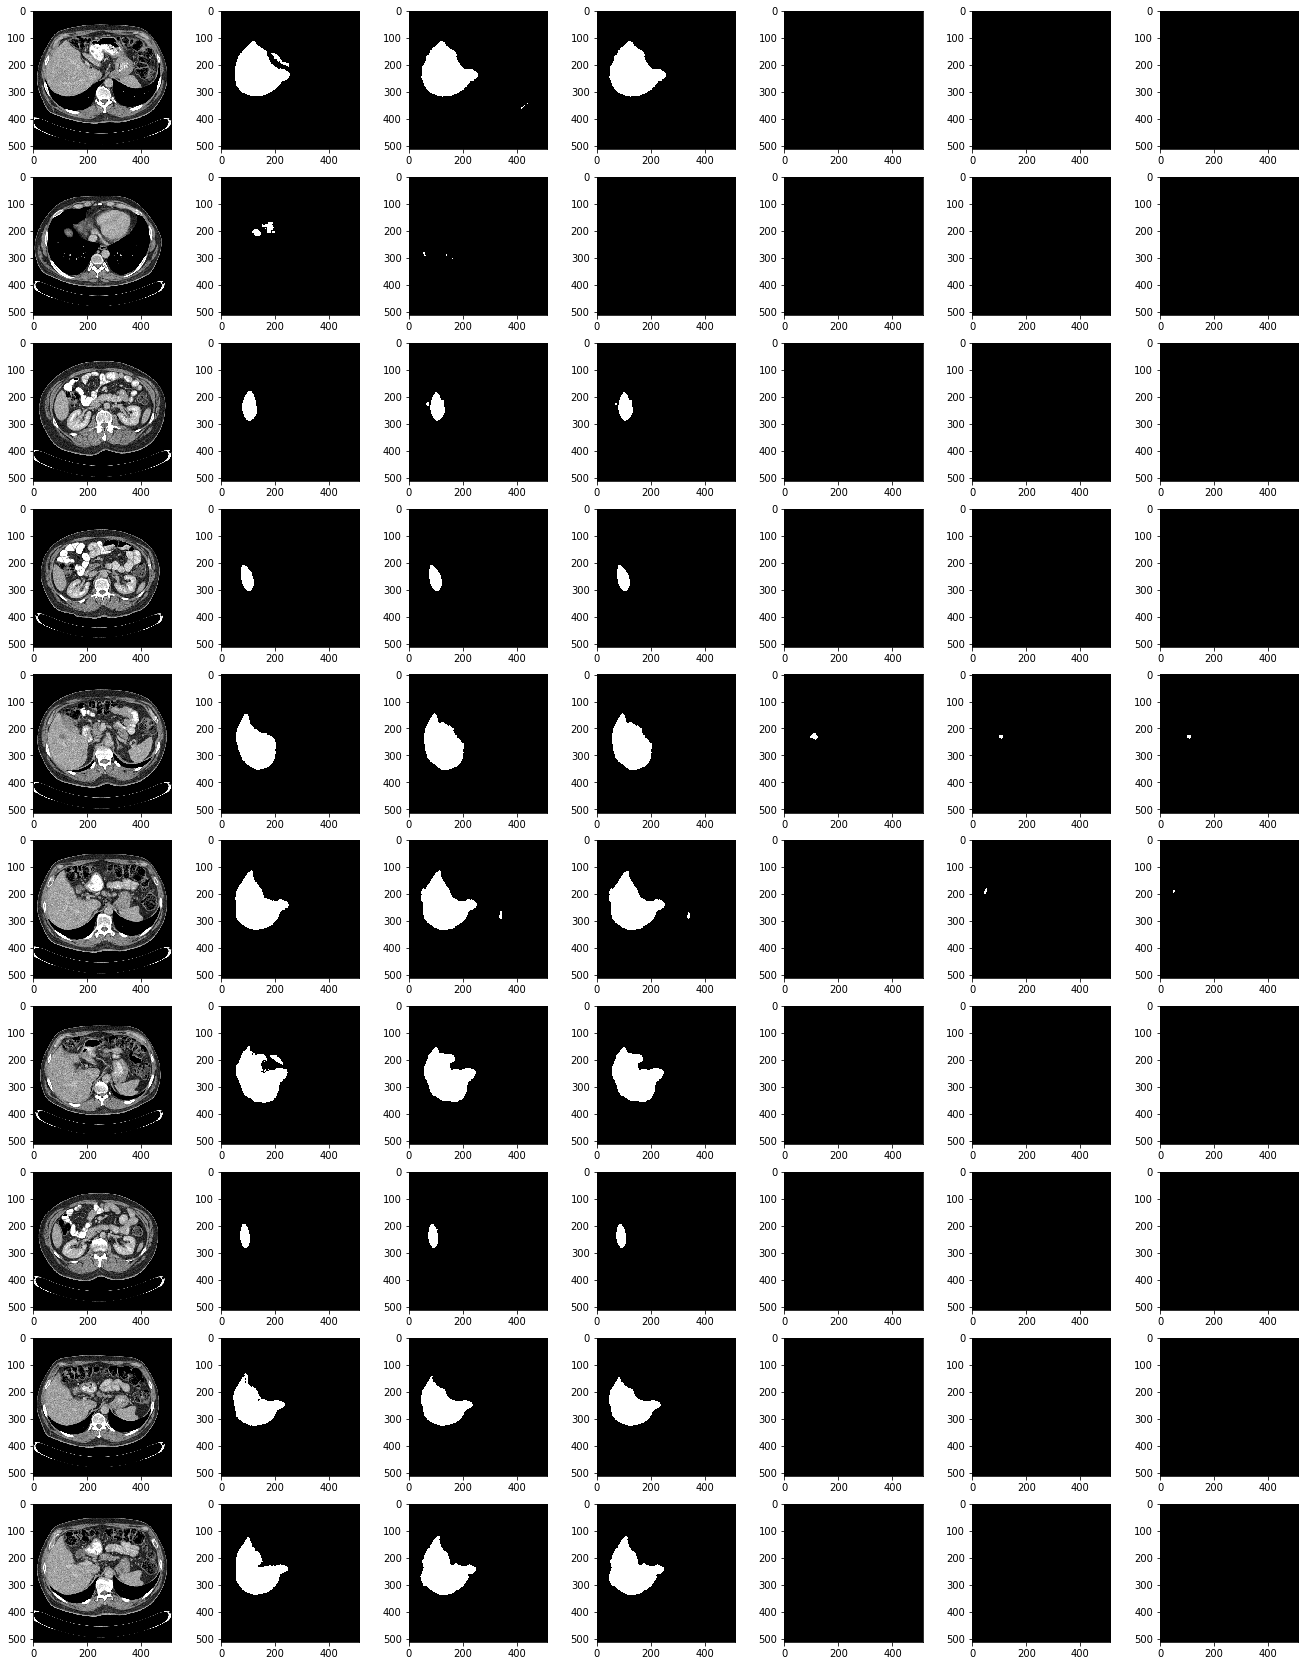

In [0]:
performanceVal = calc_resutls('val', plot=True)

In [0]:
performanceVal

,Dice_liver,Dice_lesion,Precision_liver,Precision_lesion,Recall_liver,Recall_lesion
unet_avg,0.949,0.614,0.948,0.836,0.952,0.705
crf_avg,0.950,0.613,0.953,0.910,0.951,0.650
unet_min,0.000,0.000,0.000,0.000,0.000,0.000
crf_min,0.000,0.000,0.341,0.000,0.000,0.000


Found 1092 images belonging to 1 classes.
Found 1092 images belonging to 1 classes.
starting batch  1  out of  109
starting batch  2  out of  109
starting batch  3  out of  109
starting batch  4  out of  109
starting batch  5  out of  109
starting batch  6  out of  109
starting batch  7  out of  109
starting batch  8  out of  109
starting batch  9  out of  109
starting batch  10  out of  109
starting batch  11  out of  109
starting batch  12  out of  109
starting batch  13  out of  109
starting batch  14  out of  109
starting batch  15  out of  109
starting batch  16  out of  109
starting batch  17  out of  109
starting batch  18  out of  109
starting batch  19  out of  109
starting batch  20  out of  109
starting batch  21  out of  109
starting batch  22  out of  109
starting batch  23  out of  109
starting batch  24  out of  109
starting batch  25  out of  109
starting batch  26  out of  109
starting batch  27  out of  109
starting batch  28  out of  109
starting batch  29  out of  1

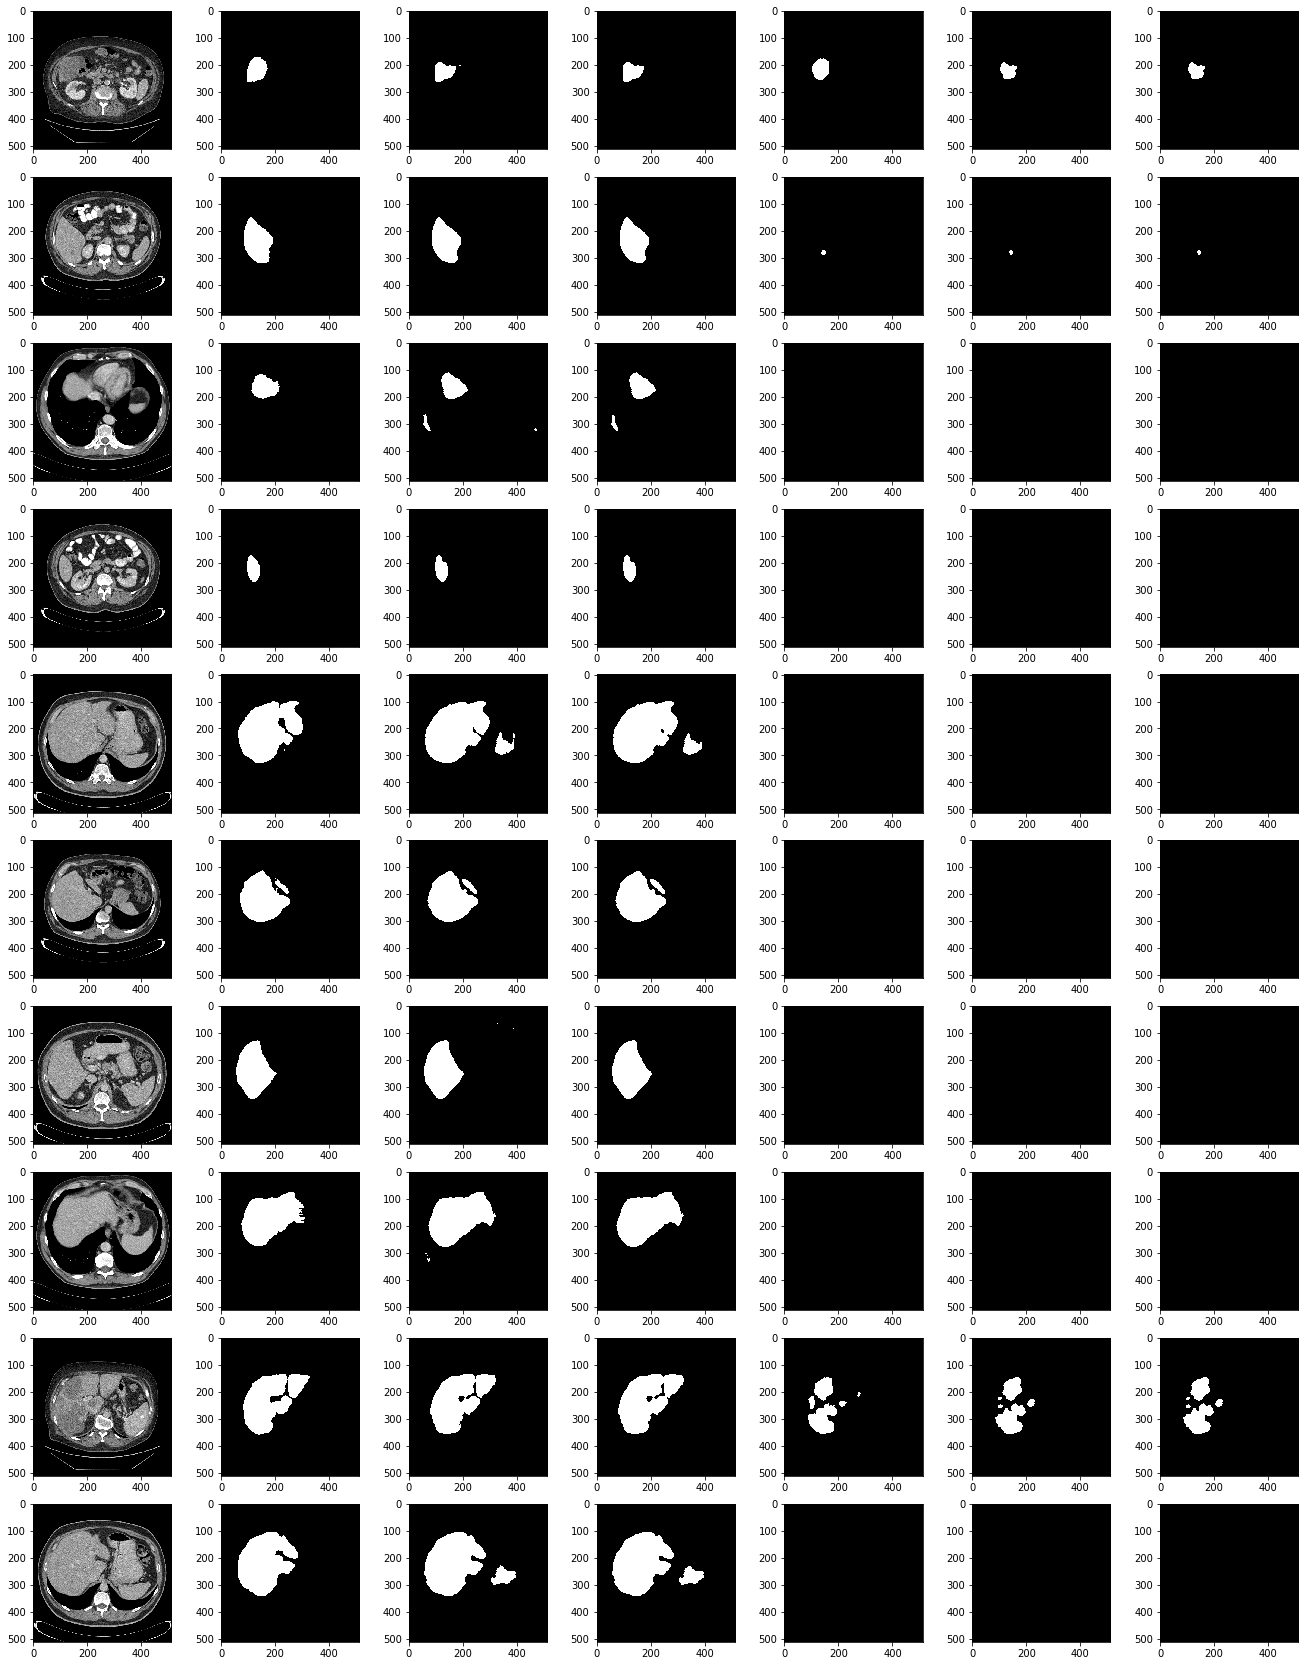

In [0]:
trainPerformance = calc_resutls('train', plot=True)

In [0]:
trainPerformance

,Dice_liver,Dice_lesion,Precision_liver,Precision_lesion,Recall_liver,Recall_lesion
unet_avg,0.948,0.786,0.939,0.906,0.961,0.818
crf_avg,0.950,0.811,0.944,0.973,0.961,0.797
unet_min,0.305,0.000,0.186,0.000,0.384,0.000
crf_min,0.316,0.000,0.194,0.000,0.368,0.000
